# Tranform coordinates

In this notebook, coordinates of all federal states are transformed to EPSG 3035 (ETRS89-extended / LAEA Europe).

In [1]:
import os
import re

from pyproj import Transformer
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from camelsp import Bundesland

/home/alexander/anaconda3/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/home/alexander/anaconda3/lib/python3.9/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [29]:
# read metadata
df = pd.read_csv("../output_data/raw_metadata/DEB_raw_metadata.csv")
df

,Nummer,Stationsname,Gewässer,Aeo,RW,HW,km oh. Münd.,PNP
0,2546015800,Nanzdietschweiler,Glan,200.940,2604686.000,5479753.000,58.000,215.499
1,2546030700,Eschenau,Glan,598.310,2607203.000,5496963.000,33.000,180.334
2,2546040900,Odenbach,Glan,1088.170,2619263.000,5507120.000,14.500,147.750
3,2546052200,Stausee Ohmbach,Ohmbach,34.500,2600311.000,5476977.000,3.600,232.367
4,2546057700,Rodenbach 2,Bruchbach,19.440,2620094.000,5483350.000,1.500,220.764
...,...,...,...,...,...,...,...,...
150,2716025700,Steinshof,Wied,NaN,NaN,NaN,NaN,NaN
151,2716050800,Brückrachdorf,Holzbach,71.800,2619609.000,5601929.000,26.700,NaN
152,2716055200,Dierdorf,Holzbach,NaN,NaN,NaN,NaN,NaN
153,2628036600,Bitburg Stausee,"Prüm, Stausee Bitburg",NaN,316797.700,5542933.300,NaN,NaN


Build a lookup dictionary which contains the source CRS, column names of X and Y coordinates, the name of the area column and the name of the ID column in the raw metadata table.

In [32]:
# build lookup dict
from camelsp.util import _NUTS_LVL2_NAMES

nuts_ids = list(_NUTS_LVL2_NAMES.keys())

# values: CRS, column names location [x, y], column name area, column name ID
_LOCATION_DICT = {
    'DE1': {'epsg': 'EPSG:25832', 'xy': ['Ost (UTM ETRS89)', 'Nord (UTM ETRS89)'], 'area': 'Einzugsgebiet in km²', 'id': 'Messstellennummer'},
    'DE2': {'epsg': 'EPSG:25832', 'xy': ['Ostwert', 'Nordwert'], 'area': 'EZG km²', 'id': 'Stationsnummer'}, # not sure about EPSG -> check, other provided columns are ('geogr. Breite', 'geogr. Länge') and ('Rechtswert (lokal)',	'Hochwert (lokal)')
    'DE4': {'epsg': 'EPSG:32633', 'xy': ['Ost/RW', 'Nord/HW'], 'area': 'CATCHMENT_SIZE', 'id': 'Messstellennummer'},
    'DE7': {'epsg': 'EPSG:25832', 'xy': ['Koordinaten X', 'Koordinaten Y'], 'area': 'Größe des Einzugsge-biets [km²]', 'id': 'Messstellen Nr.'},
    'DE8': {'epsg': 'EPSG:32633', 'xy': ['rechtswert', 'hochwert'], 'area': 'einzugsgebiet', 'id': 'pegelkennzahl'}, # not sure about EPSG
    'DE9': [], # no location in raw metadata!
    'DEA': {'epsg': 'EPSG:32632', 'xy': ['KOORDX', 'KOORDY'], 'area': 'Einzugsgebiet', 'id': 'Stationsnummer'},
    'DEB': {'epsg': 'EPSG:31466', 'xy': ['RW', 'HW'], 'area': 'Aeo', 'id': 'Nummer'}, # not sure about EPSG
    'DEC': {'epsg': 'EPSG:31466', 'xy': ['RW', 'HW'], 'area': 'EZG_Gr', 'id': 'MSTNR'}, # not sure about EPSG
    'DED': [], # no location / metadata file at all??
    'DEE': [], # no location at all??
    'DEF': {'epsg': 'EPSG:4647', 'xy': ['x', 'y'], 'area': 'area', 'id': 'id'},
    'DEG': {'epsg': 'EPSG:25832', 'xy': ['RW (GK 4)', 'HW (GK 4)'], 'area': 'EZG', 'id': 'Pegelnr'},
}

_LOCATION_DICT

{'DE1': {'epsg': 'EPSG:25832',
  'xy': ['Ost (UTM ETRS89)', 'Nord (UTM ETRS89)'],
  'area': 'Einzugsgebiet in km²',
  'id': 'Messstellennummer'},
 'DE2': {'epsg': 'EPSG:25832',
  'xy': ['Ostwert', 'Nordwert'],
  'area': 'EZG km²',
  'id': 'Stationsnummer'},
 'DE4': {'epsg': 'EPSG:32633',
  'xy': ['Ost/RW', 'Nord/HW'],
  'area': 'CATCHMENT_SIZE',
  'id': 'Messstellennummer'},
 'DE7': {'epsg': 'EPSG:25832',
  'xy': ['Koordinaten X', 'Koordinaten Y'],
  'area': 'Größe des Einzugsge-biets [km²]',
  'id': 'Messstellen Nr.'},
 'DE8': {'epsg': 'EPSG:32633',
  'xy': ['rechtswert', 'hochwert'],
  'area': 'einzugsgebiet',
  'id': 'pegelkennzahl'},
 'DE9': [],
 'DEA': {'epsg': 'EPSG:32632',
  'xy': ['KOORDX', 'KOORDY'],
  'area': 'Einzugsgebiet',
  'id': 'Stationsnummer'},
 'DEB': {'epsg': 'EPSG:31466',
  'xy': ['RW', 'HW'],
  'area': 'Aeo',
  'id': 'Nummer'},
 'DEC': {'epsg': 'EPSG:31466',
  'xy': ['RW', 'HW'],
  'area': 'EZG_Gr',
  'id': 'MSTNR'},
 'DED': [],
 'DEE': [],
 'DEF': {'epsg': 'EPSG:

Function that transforms coordinates for a given Bundesland based on the `_LOCATION_DICT`  
& function that plots the processed locations and the locations that have been processed before by opther to see if there are any differences

In [5]:
# create locations directory if it does not exist
os.makedirs("../output_data/locations", exist_ok=True)


def plot_on_germany_map(df_location, df_compare):
    # Get the world map from geopandas datasets
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Extract the boundary for Germany (ISO code 'DEU') and reproject to EPSG:3035
    germany_gdf = world[world['iso_a3'] == 'DEU']
    germany_gdf = germany_gdf.to_crs("EPSG:3035")

    # Create GeoDataFrames for the dataframes using their X and Y coordinates
    df_location_gdf = gpd.GeoDataFrame(
        df_location, geometry=gpd.points_from_xy(df_location.X, df_location.Y), crs="EPSG:3035"
    )

    df_compare_gdf = gpd.GeoDataFrame(
        df_compare, geometry=gpd.points_from_xy(df_compare.X, df_compare.Y), crs="EPSG:3035"
    )

    # Plotting the map of Germany and the dataframes
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot Germany
    germany_gdf.boundary.plot(ax=ax, color="gray", linewidth=1.2)

    # Plot df_compare with blue dots
    df_compare_gdf.plot(ax=ax, color="blue", markersize=50, label="df_compare", zorder=2)

    # Plot df_location with red crosses
    df_location_gdf.plot(ax=ax, color="red", markersize=50, marker="x", label="df_location", zorder=3)

    # Set axis limits to focus on Germany
    ax.set_xlim(4e6, 4.7e6)  # X range of Germany in EPSG:3035
    ax.set_ylim(2.65e6, 3.6e6)  # Y range of Germany in EPSG:3035

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()


def transform_coords(nuts_id: str, location_dict: dict) -> None:
    if nuts_id not in location_dict.keys():
        raise ValueError(f"[{nuts_id}]: nuts_id {nuts_id} not contained in given location_dict.")
    
    # if location_dict[nuts_id] is empty, no location is available, load the location.csv from CAMELS folder (processed by hand?)
    if not location_dict[nuts_id]:
        df_location = pd.read_csv(f"/home/alexander/bwSyncShare/CAMELS_private/locations_vgl/{nuts_id}_Locations.csv")
        
        # make copy of df_location, else, a geometry column is added in plot_on_germany_map
        df_location_copy = df_location.copy()
        plot_on_germany_map(df_location_copy, df_location_copy)

        # ask user if location should be saved as csv
        input_save = input('Do you want to save df_location as a CSV file? (y/n): ')

        # write locations dataframe to folder locations
        if input_save == 'y':
            df_location.to_csv(f"../output_data/locations/{nuts_id}_Locations.csv", index=False)
            print(f"Location for {nuts_id} saved as CSV.") 
            
        print(f"[{nuts_id}]: No location available in raw metadata, using location.csv from CAMELS folder (processed by hand?)")

        return df_location
    
    # read raw metadata file for selected Bundesland
    raw_meta = pd.read_csv(f"../output_data/raw_metadata/{nuts_id}_raw_metadata.csv")

    # get epsg code of source location
    from_epsg = location_dict[nuts_id]['epsg']

    # get necessary columns
    xy_columns = location_dict[nuts_id]['xy']
    area_column = location_dict[nuts_id]['area']
    id_column = location_dict[nuts_id]['id']

    # transformer from source epsg to 3035
    transformer = Transformer.from_crs(from_epsg, "EPSG:3035", always_xy=True)

    x_transformed = []
    y_transformed = []

    # transform coordinates
    for _, row in raw_meta[xy_columns].iterrows():
        x, y = row[0], row[1]

        transformed_coords = transformer.transform(x, y)
        x_transformed.append(transformed_coords[0])
        y_transformed.append(transformed_coords[1])

    # build dataframe
    df_location = pd.DataFrame({'ID': raw_meta[id_column], 'Area': raw_meta[area_column], 'X': x_transformed, 'Y': y_transformed})

    # remove eventually occuring characters from area column (e.g. ' km²') and transform to float
    df_location['Area'] = df_location['Area'].apply(lambda x: float(re.sub(',', '.', str(x).split(' ')[0].split('km')[0])) if str(x).strip() != 'nan' else np.nan)

    # compare to already processed locations (by others)
    df_compare = pd.read_csv(f"/home/alexander/bwSyncShare/CAMELS_private/locations_vgl/{nuts_id}_Locations.csv")
 
    # Set the float format option
    pd.options.display.float_format = '{:.3f}'.format

    # drop possible duplicates
    df_location = df_location.drop_duplicates(subset='ID')

    # sort both dfs by ID column
    df_location = df_location.sort_values(by='ID', ignore_index=True)
    df_compare = df_compare.sort_values(by='ID', ignore_index=True)

    # round dataframes, as precisssions are not necessarily the same
    if round(df_location, 0).equals(round(df_compare, 0)):
        print(f"{nuts_id}: OK\n")
    else:
        print(f"{nuts_id}: The produced location file seems to be different from the already produced file (by others)!\n")

    # print head of both dataframes for visual comparison
    print('df_location:')
    print(df_location)
    print('df_compare')
    print(df_compare)

    # make copy of df_location, else, a geometry column is added in plot_on_germany_map
    df_location_copy = df_location.copy()

    # plot new and old locations for comparison
    plot_on_germany_map(df_location_copy, df_compare)

    # ask user if location should be saved as csv
    input_save = input('Do you want to save df_location as a CSV file? (y/n): ')

    # write locations dataframe to folder locations
    if input_save == 'y':
        df_location.to_csv(f"../output_data/locations/{nuts_id}_Locations.csv", index=False)
        print(f"Location for {nuts_id} saved as CSV.") 

    return df_location

DEB: The produced location file seems to be different from the already produced file (by others)!

df_location:
             ID     Area           X           Y
0    2372030500  253.430 4165890.164 2883991.617
1    2372060000  345.200 4181207.537 2877012.409
2    2373011600   67.560 4194343.166 2883393.980
3    2375000000  103.170 4196370.490 2889444.766
4    2375010200   24.130 4184789.005 2886007.932
..          ...      ...         ...         ...
150  2722050800  182.880 4171347.900 3076304.244
151  2723050100   14.390 4163721.605 3081639.103
152  2724030100  218.500 4162177.107 3068726.995
153  2724070900   59.190 4163638.872 3068300.965
154  2725090600 1246.000 4157588.714 3076783.299

[155 rows x 4 columns]
df_compare
                ID    Area           X           Y
0    2581119000100  25.400 4203279.331 3093278.133
1    2721221000100   0.140 4198145.120 3087187.290
2    2721230000100   0.360 4193054.849 3084538.197
3    2721342000100   3.270 4192423.497 3090237.329
4    27213

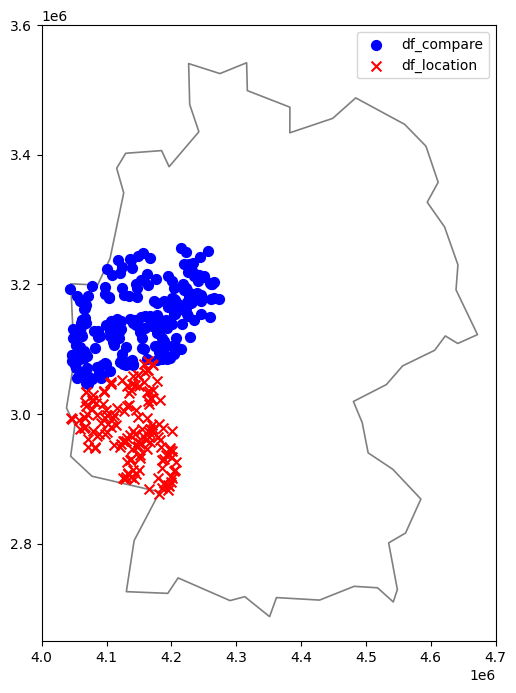

Location for DEB saved as CSV.


In [35]:
df = transform_coords(nuts_id='DEB', location_dict=_LOCATION_DICT)